# Aims of this script:

Analyse existing water tables to understand potential sources of error and undertake an uncertainty analysis.

To value-add existing water table maps by understanding flow directions, magnitudes, recharge/discharge zones, and geologic structures.

What is the study area?

BoundingBox(left=138.92013888913038, bottom=-26.04598588667808, right=140.1162636646685, top=-24.849861111139962)

# Importing packages

In [2]:
import affine
import contextily
import fiona
from __future__ import division
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.features import rasterize
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT
from rasterio import Affine

from requests import Request
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
from owslib.wcs import WebCoverageService



%matplotlib notebook

# Check out what versions I am using

To find out GDAL version: use command prompt
GDAL 2.3.3, released 2018/12/14. Got this by typing into conda prompt: `gdalinfo --version`

In [3]:
print('python version: {}' .format(sys.version))
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pyproj version: {}'.format(pyproj.__version__))
gpd.show_versions()

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.4
pandas version: 1.3.4
matplotlib version: 3.5.0
pyproj version: 3.3.0

SYSTEM INFO
-----------
python     : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
executable : C:\Users\mar886\Anaconda3\envs\geo_env\python.exe
machine    : Windows-10-10.0.19042-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.3.3
GDAL data dir: None
PROJ       : 8.2.0
PROJ data dir: C:\Users\mar886\Anaconda3\envs\geo_env\Library\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.10.2
pandas     : 1.3.4
fiona      : 1.8.20
numpy      : 1.21.4
shapely    : 1.8.0
rtree      : 0.9.7
pyproj     : 3.3.0
matplotlib : 3.5.0
mapclassify: 2.4.3
geopy      : 2.2.0
psycopg2   : None
geoalchemy2: None
pyarrow    : None
pygeos     : None


# Set up folder structures

In [4]:
os.chdir(r'C:\Users\mar886\WaterTableProject\aewt_project')
print("Current Directory", os.getcwd())

# Make folders for data and figures
if not os.path.exists("input_data"):
    os.makedirs("input_data")
       
if not os.path.exists("figures"):
    os.makedirs("figures")
    
if not os.path.exists("output_data"):
    os.makedirs("output_data")

Current Directory C:\Users\mar886\WaterTableProject\aewt_project


# Projection set ups

In [5]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32755')
gda94 = pyproj.CRS('epsg:4283')
austalbers = pyproj.CRS('epsg:3577')

# Set up the bounding box

This is in wgs84

In [6]:
leftbbox = 138.92013888913038
bottombbox = -26.049861111151657
rightbbox = 140.1198611113643
topbbox = -24.849861111139962

# Set up the figure formatting

In [7]:
 wt_cmap = "viridis_r"
dem_cmap = "terrain"

plt_extent = [leftbbox, rightbbox, bottombbox, topbbox]

## Make a geodataframe of the bounding box to crop with.

Study extent as a polygon `studyarea` or geodataframe `sa_gdf`, or as a rasterio bounding box (for raster files).
Geodaframe is what works best for cropping.

In [8]:
studyarea = shapely.geometry.box(leftbbox, bottombbox, rightbbox, topbbox) # minx, miny, maxx, maxy
print("Study area polygon type is: %s " %type(studyarea))
print("Study area is: %s" %(studyarea,))

print("Area of the study area is: %1.1f square degrees" % studyarea.area)
print("Length of the study area is: %1.1f square degrees" % studyarea.length)

sa_df = pd.DataFrame()
sa_df["geometry"] = [studyarea]
sa_gdf = gpd.GeoDataFrame(sa_df, geometry='geometry',crs=wgs84)
print("Study area gdf type is: %s " % type(sa_gdf))

sa_bbox = rasterio.coords.BoundingBox(leftbbox, bottombbox, rightbbox, topbbox)

print("Study area rasterio bbox type is: %s " %type(sa_bbox))

Study area polygon type is: <class 'shapely.geometry.polygon.Polygon'> 
Study area is: POLYGON ((140.1198611113643 -26.049861111151657, 140.1198611113643 -24.849861111139962, 138.92013888913038 -24.849861111139962, 138.92013888913038 -26.049861111151657, 140.1198611113643 -26.049861111151657))
Area of the study area is: 1.4 square degrees
Length of the study area is: 4.8 square degrees
Study area gdf type is: <class 'geopandas.geodataframe.GeoDataFrame'> 
Study area rasterio bbox type is: <class 'rasterio.coords.BoundingBox'> 


### Save the bounding box as a shape file

In [ ]:
sa_gdf.to_file(os.path.join("output_data", "studyarea.shp"))

# Digital Elevation Model (DEM)

### First, open the raster.

I am having trouble downloading it directly from the webserver for now.

In [9]:
dem_fname = "Hydro_Enforced_1_Second_DEM.tif"
dem_rstr_path = os.path.join("input_data", "Elvis_dl_15Nov21_geotiff", dem_fname)

dem_rstr = rasterio.open(dem_rstr_path)
print(type(dem_rstr))

print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print("DEM raster mode is: %s" %dem_rstr.mode)
print("Is the DEM raster closed?: %s" %dem_rstr.closed)

<class 'rasterio.io.DatasetReader'>
DEM raster crs is: EPSG:4326
DEM raster shape: (4306, 4306)
DEM raster type: <class 'rasterio.io.DatasetReader'>
DEM raster mode is: r
Is the DEM raster closed?: False


### Second, download the raster directly to be an array, with the metadata stored separately.

Instead of `dem_ar = grd.read()[0,:,:]` I could also use `dem_ar = grd.read(1)`, each band is indexed starting at 1 (not 0 like in Python).

Make a mask from this DEM - it is the shape I will base my other downloads on.

In [10]:
with rasterio.open(dem_rstr_path) as grd:
    dem_ar = grd.read()[0,:,:]
    dem_meta = grd.profile   
    dem_bounds = grd.bounds
    dem_res = grd.res
    
mask = np.zeros_like(dem_ar)
nrows,ncols = np.shape(mask)

### Plot the DEM raster

There is a hidden image underneath because I can't figure out how to add a colour bar to the rasterio `show` command.

<IPython.core.display.Javascript object>


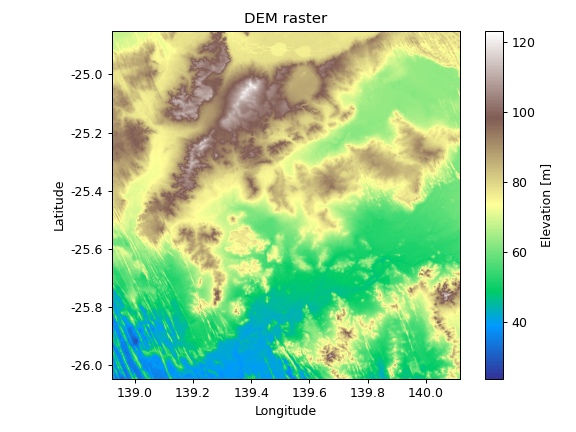

In [11]:
fig, (ax1) = plt.subplots(1, 1)

image_hidden = ax1.imshow(dem_ar, cmap=dem_cmap)

show(dem_rstr, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

ax1.set_title('DEM raster')

cbar = plt.colorbar(image_hidden)
cbar.set_label('Elevation [m]')

plt.tight_layout()


# Water table contours data

These are saved as shapefiles.

In [12]:
wt_contour_fldr = os.path.join("input_data", "GAB_WT", "Watertable_Contour",
                               "wt_contour.shp")

wt_contour = gpd.read_file(wt_contour_fldr)

print("WT contour raster crs is: %s" % wt_contour.crs)

WT contour raster crs is: PROJCS["GABWRA_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",143],PARAMETER["standard_parallel_1",-21],PARAMETER["standard_parallel_2",-29],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


### Convert the coordinates of water table contour to be the same as the DEM

I should change it so that it is the other way around - DEM the same as the wt crs because Albers Equal Area Projection is a better choice.

In [13]:
wt_contour = wt_contour.to_crs(wgs84)
print("WT contour raster crs is: %s" % wt_contour.crs)

WT contour raster crs is: epsg:4326


### Plot the water table contours

Save the figure into the designated figures folder.

<IPython.core.display.Javascript object>


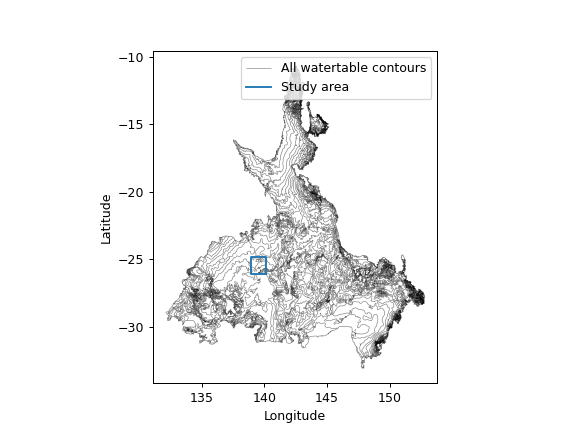

In [14]:
fig, ax = plt.subplots(1,1)
wt_contour.plot(ax=ax, color="k", alpha=0.5, linewidth=0.5, label="All watertable contours")

plt.plot(*studyarea.exterior.xy, label="Study area")

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.legend()

# Save figure
plt.savefig(os.path.join("figures", "original_contours"), dpi=300)

# Crop the water table contours to the study area

## 1. Get rid of all contours that aren't the water table contours (i.e. GAB boundary)

Need to check that the study area and the water table contours are in the same crs
Then make a copy of the dataframe so I can add the intersection geoseries over the top

In [15]:
wt_contour_filtr = wt_contour[wt_contour['height']>-9999]

if sa_gdf.crs == wt_contour_filtr.crs:
    print("Study area and water table contours are in the same crs")
else:
    print("Study area and water table contours are not in the same crs - conversion required")
    
contours_icpt_gdf = wt_contour_filtr.copy()

print(len(wt_contour))
print(len(contours_icpt_gdf))

Study area and water table contours are in the same crs
2832
1122


## 2. Crop contours based on the study area

In [16]:
contours_icpt_gdf['contours_icpt'] = wt_contour_filtr.intersection(sa_gdf.geometry[0])

## 3. Get only values where the geometry is not empty

In [17]:
is_empty_list = []
for i in range(len(contours_icpt_gdf)):
    is_empty_list.append(contours_icpt_gdf.iloc[i, 4].is_empty)
print(len(is_empty_list))

contours_icpt_gdf['is_empty'] = is_empty_list
contours_icpt_gdf_notempty = contours_icpt_gdf[contours_icpt_gdf['is_empty'] == False]

print(len(contours_icpt_gdf_notempty))

1122
5


### Plot the water table contours that intersect the study are and are not empty

<IPython.core.display.Javascript object>


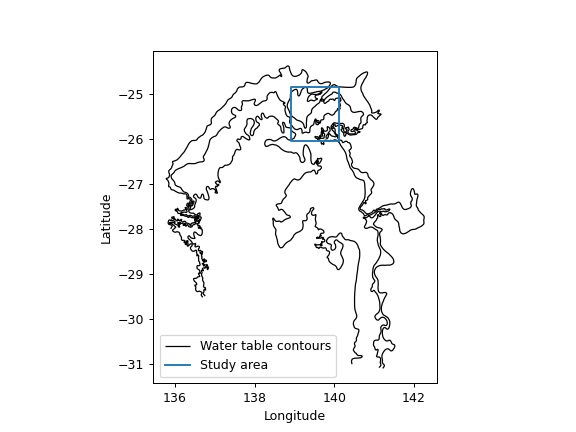

In [18]:
fig, ax = plt.subplots()
contours_icpt_gdf_notempty.plot(ax=ax, color="k", linewidth=1, label = "Water table contours")
plt.plot(*studyarea.exterior.xy, label="Study area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.legend()

### 4. Make a new gdf where the name geometry is changed

This is because the intercept column is actually the geometry.

Now it is a geopandas object and is the right shape, cropped to the study area.

In [19]:
contours_sa = contours_icpt_gdf_notempty.copy()
contours_sa = contours_sa.drop(labels="geometry", axis=1)

contours_sa = contours_sa.rename(columns={"contours_icpt":"geometry"})
print(len(contours_sa))


5


### Plot the water table contours cropped to the study area

<IPython.core.display.Javascript object>


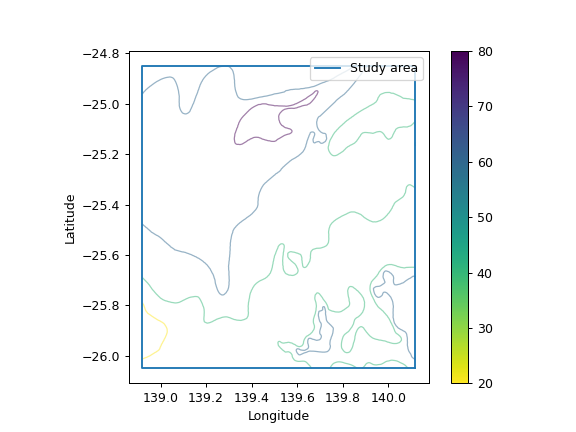

In [20]:
fig, ax = plt.subplots()
contours_sa.plot(ax=ax, column=contours_sa["height"], 
                 alpha=0.5, cmap=wt_cmap, linewidth=1, legend=True)
plt.plot(*studyarea.exterior.xy, label="Study area")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')

## Plot the DEM data with the water table contours 

Where the water table contours are shapefiles.

<IPython.core.display.Javascript object>


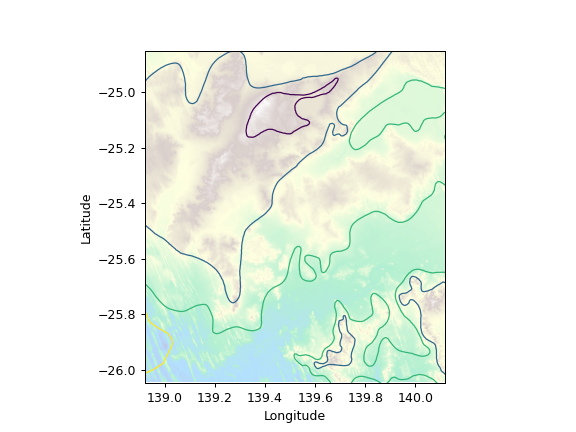

In [21]:
fig1, ax1 = plt.subplots()

show(dem_rstr, ax=ax1, cmap="terrain", alpha=0.3)

contours_sa.plot(ax=ax1, column=contours_sa["height"],
                 linewidth=1, cmap=wt_cmap)

plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax1.set_xlim([leftbbox, rightbbox])
ax1.set_ylim([bottombbox, topbbox])

plt.savefig(os.path.join("figures", "dem_with_contours"), dpi=300)

## Turn water table contours into a raster file

Here I am "burning in" the contours to a raster with the same shape as the dem array. At each contour location, the raster pixel is being assigned a value equal to the "height" category in the contours geodataframe.  All other values where there is no contour are being assigned a default value of 0 (this is the `fill` parameter). For contours that don't have a "height" value, these pixels are also being assigned a default value of 0 (this is the `default_value` parameter). 

In [22]:
wt_rstr = rasterize(
    ((s, h) for s, h in zip(contours_sa['geometry'], contours_sa['height'])),
    out_shape=dem_ar.shape,
    transform=dem_meta['transform'],
    fill = 0,
    all_touched = True,
    default_value = 0,
    dtype=rasterio.int32)

print("Min value for wt raster: %2.2f" %wt_rstr.min())
print("Max value for wt raster: %2.2f" %wt_rstr.max())
print("Shape of wt raster: %s" %(wt_rstr.shape,))

Min value for wt raster: 0.00
Max value for wt raster: 80.00
Shape of wt raster: (4306, 4306)


### Save the water table contours as a raster (tif) file 

In [27]:
print(dem_meta['crs'])
print(wt_contour.crs)
print(dem_meta['transform'])

EPSG:4326
epsg:4326
| 0.00, 0.00, 138.92|
| 0.00,-0.00,-24.85|
| 0.00, 0.00, 1.00|


In [28]:
new_fname = os.path.join("output_data", "wt_contours.tif")

new_dataset = rasterio.open(
    new_fname,
    'w',                                 # Writing the file (making a new raster)
    driver='GTiff',
    height=wt_rstr.shape[0],
    width=wt_rstr.shape[1],
    count=1,                                            # A count of the dataset bands
    dtype=str(wt_rstr.dtype),                           # Optional
    crs=dem_meta['crs'],                                 # Optional  
    transform=dem_meta['transform'])                    # Optional
     

new_dataset.write(wt_rstr, 1)
new_dataset.close()

### Plot the rasterised water level contours

Note that they are hard to see in this plot unless you zoom in because they are so thin.

<IPython.core.display.Javascript object>


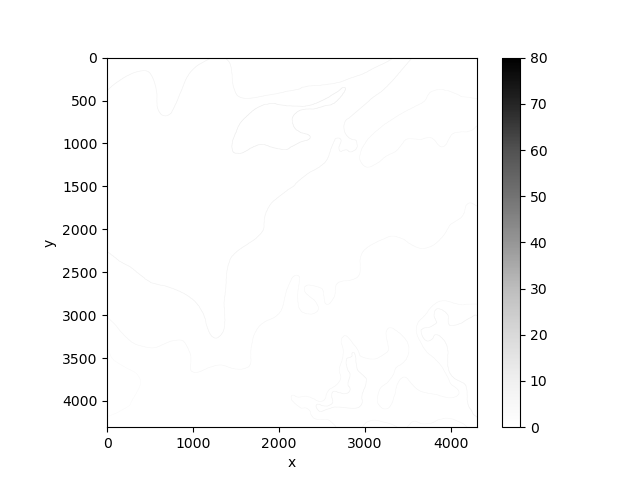

In [61]:
plt.figure()
plt.imshow(wt_rstr, cmap='Greys')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

plt.savefig(os.path.join("figures", "raster_contours"), dpi=300)

## Interpolate the water level contours

In [32]:
# This is what I want to interpolate:
wt_rstr
print(type(wt_rstr))
print(wt_rstr.shape)

<class 'numpy.ndarray'>
(4306, 4306)


Define a 3D np array based on this raster, i.e. change it to [x, y, z] values

In [33]:
x = np.arange(0, ncols)
y = np.arange(0, nrows)
xi, yi = np.meshgrid(x, y)

print("number of rows: %i should be equal to y: %i" %(nrows, len(y)))
print("number of cols: %i should be equal to x: %i" %(ncols, len(x)))

number of rows: 4306 should be equal to y: 4306
number of cols: 4306 should be equal to x: 4306


Find the points where the water table exists - this will be the basis of the interpolation. Find the value of the water table at these points.
Find the points where the water table doesn't exist - this will be where the intepolation is happening.

In [34]:
points_wt = (wt_rstr).nonzero()   
print(points_wt)
values_wt = wt_rstr[points_wt]
print(values_wt)
points_no_wt = np.where(wt_rstr == 0) 
print(points_no_wt)

(array([   0,    0,    0, ..., 4305, 4305, 4305], dtype=int64), array([1288, 1289, 1290, ..., 3493, 4188, 4189], dtype=int64))
[60 60 60 ... 40 40 40]
(array([   0,    0,    0, ..., 4305, 4305, 4305], dtype=int64), array([   0,    1,    2, ..., 4303, 4304, 4305], dtype=int64))


## Interpolate the water level at all points there is not already a water table value

Using three different interpolation techniques:<br> `z0` = nearest neighbour,<br> `z1` = linear,<br> `z2` = cubic.

In [35]:
grid_wt_z0 = griddata(points_wt, values_wt, (xi, yi), method='nearest')
grid_wt_z1 = griddata(points_wt, values_wt, (xi, yi), method='linear')
grid_wt_z2 = griddata(points_wt, values_wt, (xi, yi), method='cubic')

## Plot the results

<IPython.core.display.Javascript object>


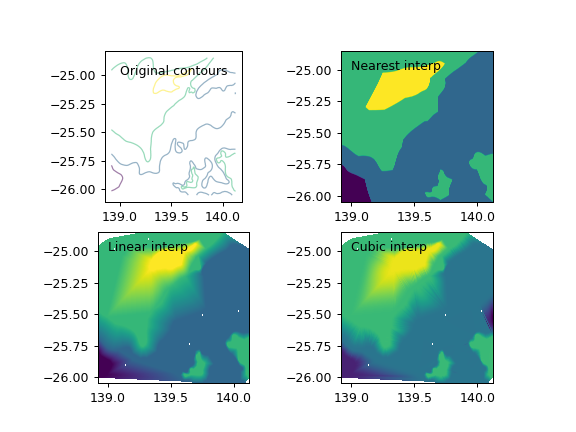

In [36]:
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
contours_sa.plot(ax=ax1, column=contours_sa["height"], alpha=0.5, linewidth=1)
#ax1.set_xlim([xmin, xmax])
#ax1.set_ylim([ymin, ymax])
ax1.text(139, -25, "Original contours")


ax2 = plt.subplot(2, 2, 2)
plt.imshow(np.flipud(grid_wt_z0.T), extent=plt_extent, origin='lower')
ax2.text(139, -25, "Nearest interp")


ax3 = plt.subplot(2, 2, 3)
plt.imshow(np.flipud(grid_wt_z1.T), extent=plt_extent, origin='lower')
ax3.text(139, -25, "Linear interp")


ax4 = plt.subplot(2, 2, 4)
plt.imshow(np.flipud(grid_wt_z2.T), extent=plt_extent, origin='lower')
ax4.text(139, -25, "Cubic interp")

plt.savefig(os.path.join("figures", "wt_interps"), dpi=300)

## Making a comparison between the water table contours and DEM

In [37]:
wt_raster_optns = [grid_wt_z0,
                   grid_wt_z1,
                   grid_wt_z2]

wt_raster_idx = 0

### Choose wt raster to work with

In [38]:
wt_raster = wt_raster_optns[wt_raster_idx].T #grid_wt_z0.T

print("DEM max: %2.2f, Water table max: %2.2f " %(np.nanmax(dem_ar), np.nanmax(wt_raster)))
print("DEM min: %2.2f, Water table min: %2.2f " %(np.nanmin(dem_ar), np.nanmin(wt_raster)))
print("DEM average: %2.2f, Water table average: %2.2f " %(np.nanmean(dem_ar), np.nanmean(wt_raster)))
print("DEM st deviation: %2.2f, Water table st deviation: %2.2f " %(np.nanstd(dem_ar), np.nanstd(wt_raster)))

DEM max: 123.11, Water table max: 80.00 
DEM min: 23.71, Water table min: 20.00 
DEM average: 70.25, Water table average: 50.61 
DEM st deviation: 16.75, Water table st deviation: 13.83 


### Check if there are any places where the height of the DEM is below wt

In [39]:
residual_dem_wt = dem_ar - wt_raster

print("Max of residuals: %2.2f" %np.nanmax(residual_dem_wt))
print("Min of residuals: %2.2f" %np.nanmin(residual_dem_wt))
print("Mean of residuals: %2.2f" %np.nanmean(residual_dem_wt))
print("Standard deviation of residuals: %2.2f" %np.nanstd(residual_dem_wt))

max_diff = max(abs(np.nanmin(residual_dem_wt)), 
               abs(np.nanmax(residual_dem_wt)))

Max of residuals: 57.58
Min of residuals: -13.35
Mean of residuals: 19.64
Standard deviation of residuals: 10.83


<IPython.core.display.Javascript object>


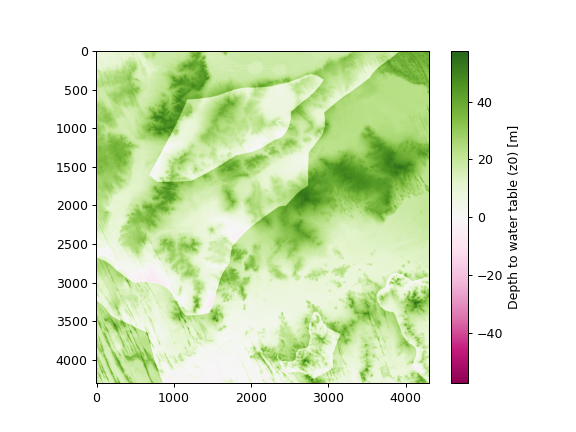

In [40]:
plt.figure()
ax1 = plt.subplot(1, 1, 1)
img1 = plt.imshow(residual_dem_wt, cmap="PiYG", vmin=-max_diff, vmax=max_diff)

cb1 = plt.colorbar(img1)  
cb1.set_label('Depth to water table (z%i) [m]' %wt_raster_idx)

plt.savefig(os.path.join("figures", "diff_dem_wt_%i" %wt_raster_idx), dpi=300)


### Look at places where residuals are < 0, i.e. the DEM is higher than the wt

<IPython.core.display.Javascript object>


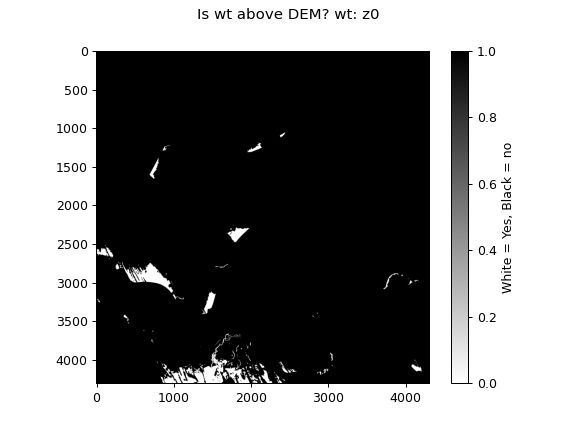

In [41]:
wt_abv_dem_idx = np.where(residual_dem_wt > 0) 
wt_abv_dem_values = residual_dem_wt[wt_abv_dem_idx] # This gets me the values
wt_abv_dem = residual_dem_wt > 0                    # This shows results as a Boolean array

plt.figure()
plt.suptitle("Is wt above DEM? wt: z%i" %wt_raster_idx)
ax1 = plt.subplot(1, 1, 1)
img1 = plt.imshow(wt_abv_dem, cmap="binary")
cbar = plt.colorbar(img1)
cbar.set_label("White = Yes, Black = no")

plt.savefig(os.path.join("figures", "wt_abv_dem_z%i" %wt_raster_idx), dpi=300)

### Perform regression analysis between the elevation and the water table

Start by flattening the arrays for the regression analysis.

In [42]:
dem_flat        = dem_ar.flatten()
wt_raster_flat  = wt_raster.flatten()

print(dem_flat.shape)
print(wt_raster_flat.shape)

(18541636,)
(18541636,)


### Then create mask of locations with nans and perform regression analysis with masked values.
`~` means "is not" (only in np)

In [43]:
mask = ~np.isnan(dem_flat) & ~np.isnan(wt_raster_flat)

res = stats.linregress(dem_flat[mask], wt_raster_flat[mask])
res.slope    
r2 = (res.rvalue)**2

### Plot the regression slope

<IPython.core.display.Javascript object>


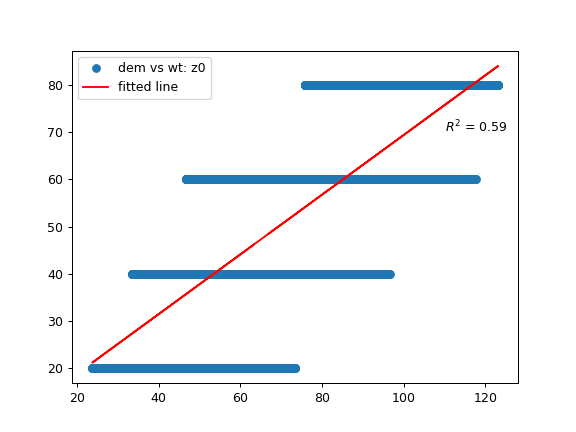

In [44]:
fig, ax = plt.subplots(1,1)
ax.plot(dem_flat, wt_raster_flat, 'o', label='dem vs wt: z%i' %wt_raster_idx)
ax.plot(dem_flat, res.intercept + res.slope*dem_flat, 'r', label='fitted line')
ax.text(110, 70, "$R^2$ = %2.2f" %r2)
ax.legend()
plt.savefig(os.path.join("figures", "wt_dem_linearregr_z%i" %wt_raster_idx), dpi=300)

### Save each of the interpolated water tables as raster files

In [47]:
for z in range(len(wt_raster_optns)):    
    wt_interp_ar = wt_raster_optns[z]
    new_fname = os.path.join("output_data", "wt_interp_%i.tif" %z)
    print(new_fname)
    
    new_dataset = rasterio.open(
    new_fname,
    'w',                                 # Writing the file (making a new raster)
    driver='GTiff',
    height=wt_rstr.shape[0],
    width=wt_rstr.shape[1],
    count=1,                                            # A count of the dataset bands
    dtype=str(wt_rstr.dtype),                           # Optional
    crs=dem_meta['crs'],                                # Optional  
    transform=dem_meta['transform'])                    # Optional
     

    new_dataset.write(wt_interp_ar, 1)
    new_dataset.close()

output_data\wt_interp_0.tif
output_data\wt_interp_1.tif
output_data\wt_interp_2.tif


# River network data

### First step: download river data from Geofabric.

Here I am accessing the data directly from a webservice. The  url accesses BoM Geofabric Surface Hydrology Cartography. The study area is the same as the study area used from the DEM file - it is using the rasterio version `sa_bbox` (but could be specified in other ways too).

In [49]:
WfsUrl = 'http://geofabric.bom.gov.au/simplefeatures/ahgf_shcarto/ows'
params = dict(service='WFS', 
              version='1.0.0', 
              request='GetFeature',
              typename='ahgf_shcarto:AHGFMappedStream', 
              bbox='%f,%f,%f,%f' % (sa_bbox[0],sa_bbox[1],sa_bbox[2],sa_bbox[3]),
              outputFormat='json')

q = Request('GET',WfsUrl,params=params).prepare().url
riv_wgs = gpd.read_file(q)
riv_wgs.crs # Already in wgs84
river_gdf = riv_wgs.to_crs(wgs84)

print(type(river_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


### Plot the river network

<IPython.core.display.Javascript object>


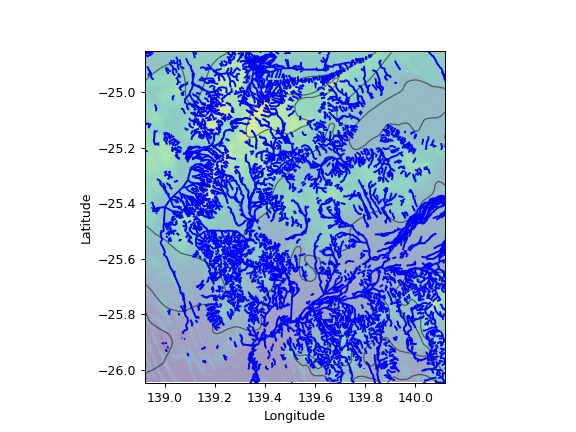

In [50]:
fig1, ax1 = plt.subplots()
show(dem_rstr, ax=ax1, alpha=0.5)
contours_sa.plot(ax=ax1, color="k", alpha=0.5, linewidth=1)
river_gdf.plot(ax=ax1, edgecolor='b')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax1.set_xlim([leftbbox, rightbbox])
ax1.set_ylim([bottombbox, topbbox])

plt.savefig(os.path.join("figures", "dem_riv_contours"), dpi=300)

## Rasterise the river network

First I will check out what are the columns of the river data - i.e. what features have been defined?

Printed below shows that the only categories for the 'heirarchy' column are 'Major' or 'Minor'

In [51]:
print(river_gdf.columns)
print(river_gdf['hierarchy'].unique())

Index(['id', 'hydroid', 'ahgfftype', 'name', 'hierarchy', 'perennial',
       'aushydroid', 'from_node', 'to_node', 'nextdownid', 'enabled',
       'flowdir', 'srcfcname', 'srcftype', 'srctype', 'sourceid', 'featrel',
       'fsource', 'attrrel', 'attrsource', 'planacc', 'symbol', 'textnote',
       'geodeslen', 'upstrgeoln', 'shape_length', 'geometry'],
      dtype='object')
['Major' 'Minor']


Here, I am only selecting the "major" rivers, but I can change this and use all of them or select via a different attribute.

In [52]:
river_index = river_gdf.hierarchy=='Major'

## Now create the raster of major rivers

Again, I am burning into a raster with the same shape as the DEM array. In this case, at each pixel where there is a river, it will be assigned the default value of "hydroid". But this isn't very helpful to me - so below I just change it so that at each river the pixel is assigned a value of 1 (and not the value of the hydroid).

In [53]:
rivers_ar = rasterize(
    ((s, v) for s, v in zip(river_gdf[river_index].geometry, 
                            river_gdf[river_index].hydroid)),
    out_shape=dem_ar.shape,
    transform=dem_meta['transform'],
    fill = 0,
    all_touched = True,
    default_value = 0,
    dtype=rasterio.int32)

print("Min value for rivers raster: %2.2f" %rivers_ar.min())
print("Max value for rivers raster: %2.2f" %rivers_ar.max())
print("Shape of rivers raster: %s" %(rivers_ar.shape,))

rivers_ar[rivers_ar > 0] = 1

Min value for rivers raster: 0.00
Max value for rivers raster: 6060551.00
Shape of rivers raster: (4306, 4306)


In [54]:
print(type(rivers_ar))

<class 'numpy.ndarray'>


## Plot the rasterised river network

Again, it is hard to see the rivers because they are quite thin on the raster which has a fine resolution.

<IPython.core.display.Javascript object>


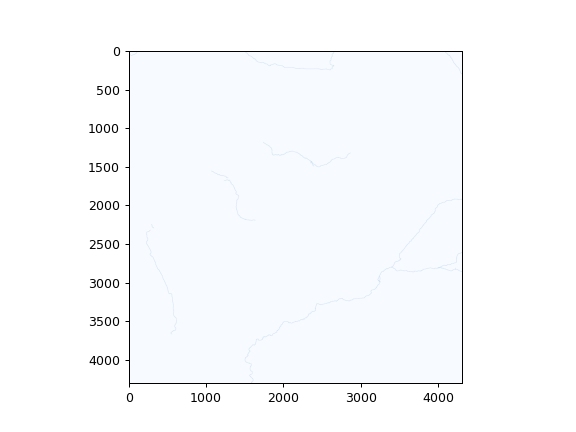

In [55]:
plt.figure()
plt.imshow(rivers_ar, cmap="Blues",interpolation=None)
plt.savefig(os.path.join("figures", "riv_raster"), dpi=300)

### Save the rasterised river network as a raster

In [56]:
new_fname = os.path.join("output_data", "river_rstr.tif")
print(new_fname)

new_dataset = rasterio.open(
new_fname,
'w',                                 # Writing the file (making a new raster)
driver='GTiff',
height=wt_rstr.shape[0],
width=wt_rstr.shape[1],
count=1,                                            # A count of the dataset bands
dtype=str(wt_rstr.dtype),                           # Optional
crs=dem_meta['crs'],                                # Optional  
transform=dem_meta['transform'])                    # Optional


new_dataset.write(rivers_ar, 1)
new_dataset.close()

output_data\river_rstr.tif


# Water table elevation raster data

Geoscience Australia also made a raster file of water table elevation (interpolated the contours using TopoToRaster tool in ArcGIS and saved it as ASCII Grid file. This file is not accompanied by a .prj file - i.e. it does not have projection information.

To overcome issues with no projection, my only work-around (for now) was to open the file in ArcGIS and convert it to a Tiff and asign it a projection, I could not figure out how to do this using Python tools.

I am calling this the `wt_rstr_real`, i.e. calling it *real* because it is one that was prepared by a third party, ideally is geologically correct and I can compare it to any interpolation that I do myself.

Note that the pixel size is completely different - it is 1000m for this file compared to 30m for the DEM.

In [57]:
wt_rstr_real_path = os.path.join("input_data", "GAB_WT", 
                           "Watertable_Elev", "ASCII_Grid",
                          'wt1.tif')

wt_rstr_real = rasterio.open(wt_rstr_real_path,
                         driverstr="GTiff")

print(type(wt_rstr_real))

<class 'rasterio.io.DatasetReader'>


## Download the wt real raster directly as an array

With meta-data stored separately

In [58]:
with rasterio.open(wt_rstr_real_path) as wtgrd:
    wt_real_ar = wtgrd.read()[0,:,:]
    wtgrid_meta = wtgrd.profile   
    wtbounds = wtgrd.bounds
    wtres = wtgrd.res

In [59]:
wt_real_extent = [wtbounds[0], wtbounds[2], wtbounds[1], wtbounds[3]]
print(wt_real_extent)

[131.7929065313367, 153.19464321761788, -33.137046551593485, -10.341478515305077]


### Filter WT Real array to remove the very low values (nan values) and change them to np.nan

In [60]:
wt_real_ar_f = np.where(wt_real_ar < 0, np.nan, wt_real_ar)

### Plot what the real water table raster looks like

<IPython.core.display.Javascript object>


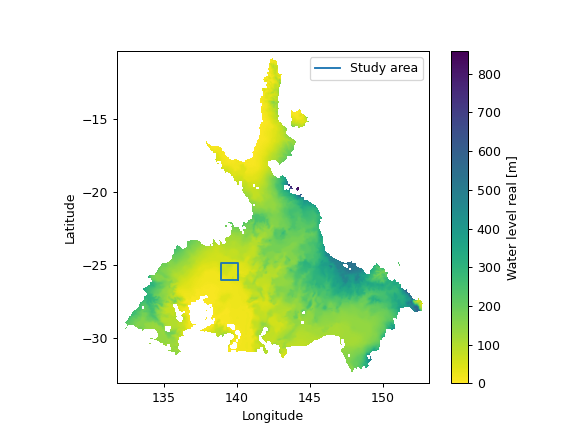

In [61]:
fig1, ax1 = plt.subplots()
img = ax1.imshow(wt_real_ar_f, cmap=wt_cmap, extent=wt_real_extent)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(*studyarea.exterior.xy, label="Study area")
cbar = plt.colorbar(img)
cbar.set_label('Water level real [m]')
plt.legend()

# Warp rasters to all have the same transformation, bounding box, and pixel size 
What are the arrays that I have now that I need all in the same resolution?  

`dem_ar`       --> the DEM  
`wt_real_ar_f` --> the 'real' water table, interpolated by GA  
`rivers_ar`    --> the rivers, from BoM Geofabric  
`grid_wt_z0`   --> interpolated water table from contours - nearest neighbour  
`grid_wt_z1`   --> interpolated water table from contours - linear  
`grid_wt_z2`   --> interpolated water table from contours - cubic 

First, check they are all the same type.

In [62]:
print(type(dem_ar))
print(type(wt_real_ar_f))
print(type(rivers_ar))
print(type(grid_wt_z0))
print(type(grid_wt_z1))
print(type(grid_wt_z2))

print(dem_ar.shape)
print(wt_real_ar_f.shape)
print(rivers_ar.shape)
print(grid_wt_z0.shape)
print(grid_wt_z1.shape)
print(grid_wt_z2.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4306, 4306)
(2306, 2165)
(4306, 4306)
(4306, 4306)
(4306, 4306)
(4306, 4306)


What are the rasters that I have and their transformations?

`dem_rstr` --> the DEM  (metadata = `dem_meta`)<br>  
`wt_rstr_real` --> the 'real' water table, interpolated by GA (metadata = `wtgrid_meta`)

### What are the different transforms?

In [63]:
print(dem_meta['transform'])
print(wtgrid_meta['transform'])

| 0.00, 0.00, 138.92|
| 0.00,-0.00,-24.85|
| 0.00, 0.00, 1.00|
| 0.01, 0.00, 131.79|
| 0.00,-0.01,-10.34|
| 0.00, 0.00, 1.00|


### What are the different resolutions?

Note that the water table is coarser - I want to convert them both to this shape and size (to this transform)

In [64]:
print(dem_res)
print(wtres)

(0.000277777777780485, 0.000277777777780485)
(0.009885328723455504, 0.009885328723455511)


## Normalise DEM and WT to a consistent grid

From here: https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html

For the input files, you use the path to the tiffs


`dem_rstr_path` --> already defined, this is the dem  
`wt_rstr_real_path` --> already defined, this is the real water table

In [65]:
riv_rstr_path = os.path.join("output_data", "river_rstr.tif")
wt_interp_z0_rstr_path = os.path.join("output_data", "wt_interp_0.tif")
wt_interp_z1_rstr_path = os.path.join("output_data", "wt_interp_1.tif")
wt_interp_z2_rstr_path = os.path.join("output_data", "wt_interp_2.tif")
wt_contours_rstr_path  = os.path.join("output_data", "wt_contours.tif")

In [71]:
input_files = (
    dem_rstr_path,
    wt_rstr_real_path,
    riv_rstr_path,
    wt_interp_z0_rstr_path,
    wt_interp_z1_rstr_path,
    wt_interp_z2_rstr_path,
    wt_contours_rstr_path
    
)

In [72]:
# Destination CRS is WGS 84
dst_crs = CRS.from_epsg(4326)

# These coordiantes are in WGS 84
dst_bounds = sa_bbox[0], sa_bbox[1], sa_bbox[2], sa_bbox[3]

# Output image dimensions
dst_height = dst_width = 120 # Approximate to size using resolution of wt raster within bounds

# Output image transform
left, bottom, right, top = dst_bounds
xres = (right - left) / dst_width
yres = (top - bottom) / dst_height
dst_transform = affine.Affine(xres, 0.0, left,
                              0.0, -yres, top)

vrt_options = {
    'resampling': Resampling.cubic,
    'crs': dst_crs,
    'transform': dst_transform,
    'height': dst_height,
    'width': dst_width,
}

## Doing the virtual warp  to each file

Save the names of the outfiles, to make it easy to see which have been created and where they were saved.

In [73]:
outfile_names = []

In [74]:
for path in input_files:

    with rasterio.open(path) as src:

        with WarpedVRT(src, **vrt_options) as vrt:

            # At this point 'vrt' is a full dataset with dimensions,
            # CRS, and spatial extent matching 'vrt_options'.

            # Read all data into memory.
            data = vrt.read()

            # Process the dataset in chunks.  Likely not very efficient.
            for _, window in vrt.block_windows():
                data = vrt.read(window=window)

            # Dump the aligned data into a new file.  A VRT representing
            # this transformation can also be produced by switching
            # to the VRT driver.
            directory, name = os.path.split(path)
            
            # Change the directory
            directory_outfiles = os.path.join("output_data", "ALIGNED")
            
            outfile = os.path.join(directory_outfiles, 'aligned-{}'.format(name))
            rio_shutil.copy(vrt, outfile, driver='GTiff')
            
            outfile_names.append(outfile)

In [77]:
print(outfile_names)
print(len(outfile_names))

['output_data\\ALIGNED\\aligned-Hydro_Enforced_1_Second_DEM.tif', 'output_data\\ALIGNED\\aligned-wt1.tif', 'output_data\\ALIGNED\\aligned-river_rstr.tif', 'output_data\\ALIGNED\\aligned-wt_interp_0.tif', 'output_data\\ALIGNED\\aligned-wt_interp_1.tif', 'output_data\\ALIGNED\\aligned-wt_interp_2.tif', 'output_data\\ALIGNED\\aligned-wt_contours.tif']
7


### Reading the aligned tifs back in

Very lazy naming for now :|

In [78]:
with rasterio.open(outfile_names[0]) as grd:
    ar_align_1 = grd.read()[0,:,:]
    meta_align_1 = grd.profile   
    bounds_align_1 = grd.bounds
    res_align_1 = grd.res

with rasterio.open(outfile_names[1]) as grd:
    ar_align_2 = grd.read()[0,:,:]
    meta_align_2 = grd.profile   
    bounds_align_2 = grd.bounds
    res_align_2 = grd.res

with rasterio.open(outfile_names[2]) as grd:
    ar_align_3 = grd.read()[0,:,:]
    meta_align_3 = grd.profile   
    bounds_align_3 = grd.bounds
    res_align_3 = grd.res
    
with rasterio.open(outfile_names[3]) as grd:
    ar_align_4 = grd.read()[0,:,:]
    meta_align_4 = grd.profile   
    bounds_align_4 = grd.bounds
    res_align_4 = grd.res
    
with rasterio.open(outfile_names[4]) as grd:
    ar_align_5 = grd.read()[0,:,:]
    meta_align_5 = grd.profile   
    bounds_align_5 = grd.bounds
    res_align_5 = grd.res
    
with rasterio.open(outfile_names[5]) as grd:
    ar_align_6 = grd.read()[0,:,:]
    meta_align_6 = grd.profile   
    bounds_align_6 = grd.bounds
    res_align_6 = grd.res
    
with rasterio.open(outfile_names[6]) as grd:
    ar_align_7 = grd.read()[0,:,:]
    meta_align_7 = grd.profile   
    bounds_align_7 = grd.bounds
    res_align_7 = grd.res

### Plot the warped/aligned files

In [ ]:
print(type(ar_align_1))
print(ar_align_1.shape)

<IPython.core.display.Javascript object>


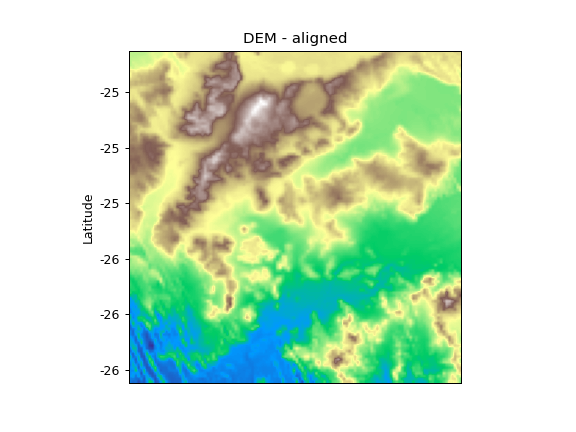

Text(0.5, 1.0, 'DEM - aligned')

In [122]:
plt.figure()

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(ar_align_1, cmap=dem_cmap, extent=plt_extent)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.0f'))
ax1.axes.get_xaxis().set_visible(False)
ax1.set_title('DEM - aligned')


<IPython.core.display.Javascript object>


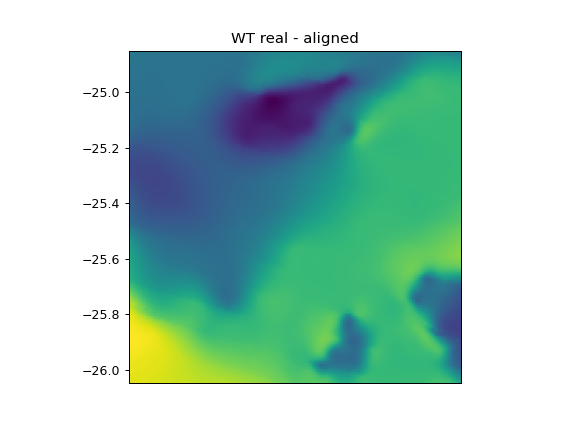

Text(0.5, 1.0, 'WT real - aligned')

In [123]:
plt.figure()
ax2 = plt.subplot(1, 1, 1)
ax2.imshow(ar_align_2, cmap=wt_cmap, extent=plt_extent)
ax2.set_xlabel("Longitude")
ax2.axes.get_xaxis().set_visible(False)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%2.0f'))
ax2.set_title('WT real - aligned')

<IPython.core.display.Javascript object>


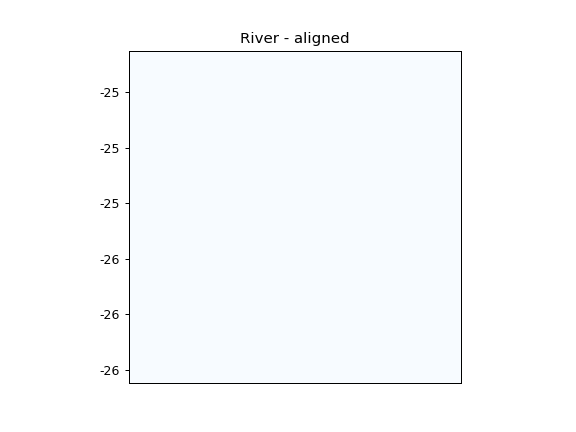

Text(0.5, 1.0, 'River - aligned')

In [127]:
plt.figure()
ax3 = plt.subplot(1, 1, 1)
ax3.imshow(ar_align_3, cmap="Blues", extent=plt_extent)
ax3.set_ylabel("")
ax3.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax3.axes.get_xaxis().set_visible(False)
ax3.set_title('River - aligned')

C:\Users\mar886\AppData\Local\Temp/ipykernel_21260/1277198602.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


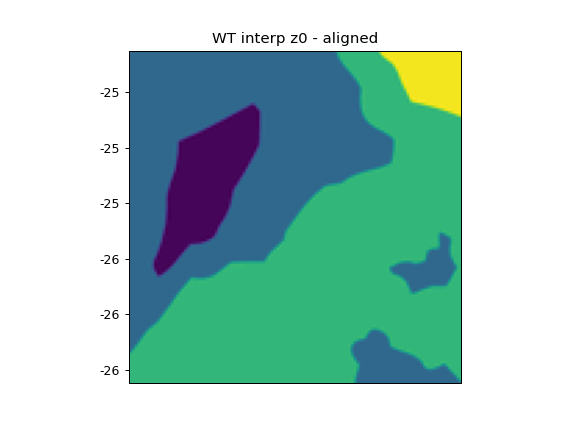

Text(0.5, 1.0, 'WT interp z0 - aligned')

In [130]:
plt.figure()
ax4 = plt.subplot(1, 1, 1)
ax4.imshow(ar_align_4, cmap=wt_cmap, extent=plt_extent)
ax4.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax4.axes.get_xaxis().set_visible(False)
ax4.set_title('WT interp z0 - aligned')

<IPython.core.display.Javascript object>


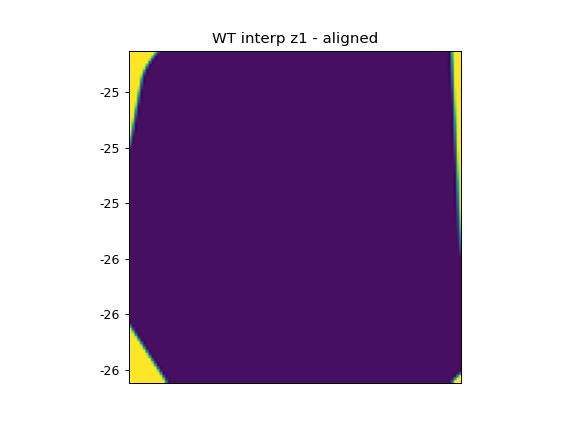

Text(0.5, 1.0, 'WT interp z1 - aligned')

In [132]:
plt.figure()
ax5 = plt.subplot(1, 1, 1)
ax5.imshow(ar_align_5, cmap=wt_cmap, extent=plt_extent)
ax5.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax5.axes.get_xaxis().set_visible(False)
ax5.set_title('WT interp z1 - aligned')

<IPython.core.display.Javascript object>


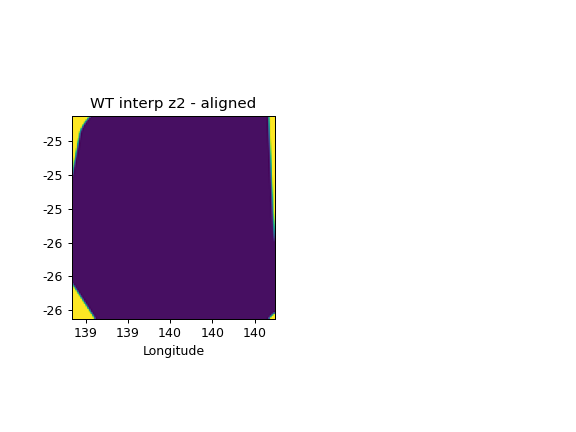

Text(0.5, 1.0, 'WT interp z2 - aligned')

In [133]:
plt.figure()
ax6 = plt.subplot(1, 2, 1)
ax6.imshow(ar_align_6, cmap=wt_cmap, extent=plt_extent)
ax6.set_xlabel("Longitude")
ax6.set_ylabel("")
ax6.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax6.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax6.set_title('WT interp z2 - aligned')

<IPython.core.display.Javascript object>


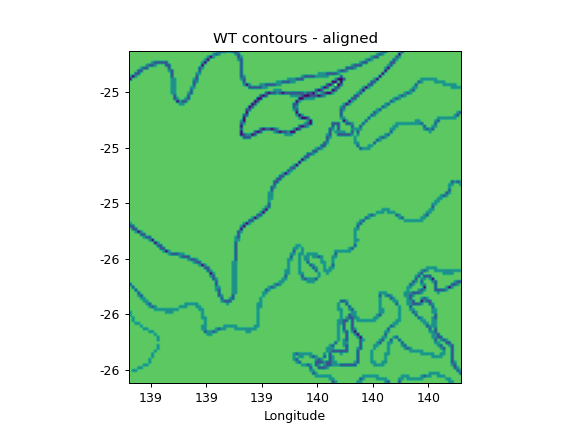

Text(0.5, 1.0, 'WT contours - aligned')

In [134]:
plt.figure()
ax7 = plt.subplot(1, 1, 1)
ax7.imshow(ar_align_7, cmap=wt_cmap, extent=plt_extent)
ax7.set_xlabel("Longitude")
ax7.set_ylabel("")
ax7.yaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax7.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
ax7.set_title('WT contours - aligned')


#plt.tight_layout()

### Check if the details align

In [118]:
print("Width, height for dem align:")
print(meta_align_1["width"], meta_align_1["height"])
print("Width, height for wt align:")
print(meta_align_2["width"], meta_align_2["height"])

print("CRS for dem align:")
print(meta_align_1["crs"])
print("CRS for wt align:")
print(meta_align_2["crs"])

print("Transform for dem align:")
print(meta_align_1["transform"])
print("Transform for wt align:")
print(meta_align_2["transform"])

print("BBox for dem align:")
print(bounds_align_1)
print("BBox for wt align:")
print(bounds_align_2)

print("Resolution for dem align:")
print(res_align_1)
print("Resolution for wt align:")
print(res_align_2)

Width, height for dem align:
120 120
Width, height for wt align:
120 120
CRS for dem align:
EPSG:4326
CRS for wt align:
EPSG:4326
Transform for dem align:
| 0.01, 0.00, 138.92|
| 0.00,-0.01,-24.85|
| 0.00, 0.00, 1.00|
Transform for wt align:
| 0.01, 0.00, 138.92|
| 0.00,-0.01,-24.85|
| 0.00, 0.00, 1.00|
BBox for dem align:
BoundingBox(left=138.92013888913038, bottom=-26.049861111151657, right=140.1198611113643, top=-24.849861111139962)
BBox for wt align:
BoundingBox(left=138.92013888913038, bottom=-26.049861111151657, right=140.1198611113643, top=-24.849861111139962)
Resolution for dem align:
(0.009997685185282516, 0.010000000000097457)
Resolution for wt align:
(0.009997685185282516, 0.010000000000097457)
